In [1]:
import plotly
import plotly.plotly as py
import plotly.figure_factory as ff
#plotly.tools.set_credentials_file(username='grace.cc.wu', api_key='mfClrA9eHWhuOwBJLR3h')
import pandas as pd
import os
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm
matplotlib.style.use('ggplot')
plt.style.use('ggplot')
pd.set_option('display.width', 1000)

# Create Master DF 
## Preprocess input CSVs

## Function: pre-process envData csv, including merge gaplc (to use inside a loop)

In [14]:
def processCSV(csv, gaplc_df):
    selSite_df = pd.read_csv(csv, keep_default_na=False)

    ''' ### ADD FLAG COLUMN, impactEval ### '''
    ## add new column for impactEval (1 = an impact assessment was performed for the env categories)
    selSite_df["impactEval"] = 1
    ## Where the area_envData_km2 column was not calculated (empty feature classes), then set value to 0 (applies to jupyter notebook anayses)
    selSite_df.loc[selSite_df.area_envData_km2.astype(str) == "NA", 'impactEval'] = 0

    ''' ### SUBSET GAPLC TO TECHNOLOGIES IN THE CSV ### '''
    techList = selSite_df["tech"].unique()
    gaplc_df_sub = gaplc_df[(gaplc_df["tech"].isin(techList))]

    ''' ### MERGE CSV WITH GAPLC ### '''
    ## merge selSite_df with the gaplc df to get all the "area_allSelSites_km2" and "selSiteExist"
    selSite_merged_df = selSite_df.merge(gaplc_df_sub[["selSites", "region", "selSitesExist", "area_allSelSites_km2", "envCat", "tech"]], how = "outer", on =  ["selSites", "region"])

    ''' ### ADD INFRASTRUCTURE COLUMN ### '''
    if "selSite" in csv:
        selSite_merged_df["infrastructure"] = "generation"
    if "tx" in csv:
        selSite_merged_df["infrastructure"] = "transmission"

    ''' ### EXPAND envData COLUMN TO JOINED GAPLC ROWS ### '''
    selSite_merged_df["envData"] = selSite_df.envData.unique()[0]

    ''' ### CONVERT area_allSelSites_km2_y TO ZERO FROM "" ### '''
    ## if sites do not exist (selSitesExist = 0), then make sure area_allSelSites_km2_y = 0 (no selected sites, or empty feature class/shapefile)
    selSite_merged_df.loc[selSite_merged_df.selSitesExist == 0, "area_allSelSites_km2_y"] = 0

    ''' ### CONVERT area_envData_km2 TO ZERO FROM NaN OR BLANK ### '''
    print(selSite_merged_df.area_envData_km2.dtype)
    ## if a column value for "area_envData_km2" is NaN, assign 0 
    selSite_merged_df.loc[(selSite_merged_df['area_envData_km2'].isna()), 'area_envData_km2'] = 0
    ## if a column value for "area_envData_km2" is == "NA", assign 0 (these are runs with empty feature classes or no selected sites) 
    selSite_merged_df.loc[(selSite_merged_df['area_envData_km2'].astype(str) =="NA"), 'area_envData_km2'] = 0
    ## if a column value for "area_envData_km2" is blank/empty, assign to value of area_allSelSites_km2_y  
    ## (for "erased" csvs, if the column is empty, that means there was complete overlap between the sites and the env dataset, so assign area_envData_km2 to area_selSite_km2)
    selSite_merged_df.loc[(selSite_merged_df['area_envData_km2'].astype(str) ==""), 'area_envData_km2'] = selSite_merged_df.area_allSelSites_km2_y
    ## convert column datatype to float 
    selSite_merged_df.area_envData_km2 = pd.to_numeric(selSite_merged_df.area_envData_km2)
    print(selSite_merged_df.area_envData_km2.dtype)

    '''### CREATE NEW COLUMNS: tech, envCat, area_allSelSites_km2 AFTER JOIN ###'''
    selSite_merged_df["area_allSelSites_km2"] = pd.to_numeric(selSite_merged_df["area_allSelSites_km2_y"])
    selSite_merged_df["tech"] = selSite_merged_df["tech_y"] 
    selSite_merged_df["envCat"] = selSite_merged_df["envCat_y"]

    '''### CREATE NEW envCat_scen TO PARSE OUT BaseUSeCat1 AS "Base" ###'''
    selSite_merged_df['envCat_scen'] = np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1"), "Base", selSite_merged_df.envCat) 

    '''### CREATE OR UPDATE FLAG COLUMNS FOR DIFFERENT "ZEROS": impactEval, scenRun ###'''
    ## impactEval: assign value of 0 for all rows that had to be added after the merge
    selSite_merged_df.loc[selSite_merged_df['impactEval'].isna(), 'impactEval'] = 0
    selSite_merged_df.impactEval = selSite_merged_df.impactEval.astype(int) 

    ## scenRun: will add the = 0 flag later when the additional rows are added for scenarios that were not run
    selSite_merged_df["scenRun"] = 1

    ''' ### PARSE OUT CATEGORICAL COLUMNS FROM selSites COLUMN ### '''
    #### geography: InState, Full_WECC, Part_WECc
    selSite_merged_df['geography'] = np.where(selSite_merged_df.selSites.str.contains("InState"), "InState", \
                                              np.where(selSite_merged_df.selSites.str.contains("Full_WECC"), "Full_WECC", \
                                                       np.where(selSite_merged_df.selSites.str.contains("Part_WECC"), "Part_WECC","NA")))

    ## RESOLVE scenario (Capped_Basecase, Capped_highDER, etc.)
    selSite_merged_df['RESOLVE_scenario'] = np.where(selSite_merged_df.selSites.str.contains("Capped_Basecase"), "Capped_Basecase",
                                  np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1_Basecase"), "Capped_Basecase",
                                           np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1_highDER"), "Capped_highDER",
                                                    np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1_lowBatt"), "Capped_lowBatt",
                                                         np.where(selSite_merged_df.selSites.str.contains("Capped_highDER"), "Capped_highDER",
                                                                 np.where(selSite_merged_df.selSites.str.contains("Capped_lowBatt"), "Capped_lowBatt",
                                                                         np.where(selSite_merged_df.selSites.str.contains("No_Cap_Basecase"), "No_Cap_Basecase",
                                                                                 np.where(selSite_merged_df.selSites.str.contains("No_Cap_highDER"), "No_Cap_highDER",
                                                                                         np.where(selSite_merged_df.selSites.str.contains("No_Cap_lowBatt"), "No_Cap_lowBatt", "NA")))))))))

    ### create new "region_final" field for state and RESOLVE Zone compatibility (remove "_%tech% from RESOLVE_zone region names" and add hyphen to New Mexico for No_Cap/W2W rows)
    selSite_merged_df["region_final"] = np.where(selSite_merged_df.region.str.contains("_Wind"), selSite_merged_df.region.str.replace("_Wind", ""), \
                                                  np.where(selSite_merged_df.region.str.contains("_Solar"), selSite_merged_df.region.str.replace("_Solar", ""),\
                                                             np.where(selSite_merged_df.region.str.contains("_Geothermal"), selSite_merged_df.region.str.replace("_Geothermal", ""), selSite_merged_df.region)))
    

    
    ## Capped vs. No_Cap
    selSite_merged_df['RESOLVE_cap'] = np.where(selSite_merged_df.RESOLVE_scenario.str.contains("Capped"), "Capped",
                                                np.where(selSite_merged_df.RESOLVE_scenario.str.contains("No_Cap"), "No_Cap", selSite_merged_df.RESOLVE_scenario))
    orig_len = len(selSite_merged_df)                                            
    '''  DONT ADD NEW ROW FOR PNW 
    ### COMBINE OR AND WA TO FORM PNW ROWS FOR W2W/STATE SCENARIOS ###
    ## sum area_envData_km2 and area_allSelSites_km2
    
    for scenario in selSite_merged_df.selSites.unique():
        subset = selSite_merged_df[(selSite_merged_df["selSites"] == scenario) & ((selSite_merged_df["region_final"] == "Oregon") | (selSite_merged_df["region_final"] == "Washington"))]
        if len(subset) >0:
            ## calculate sums
            area_envData_km2_tot = subset["area_envData_km2"].sum()
            area_allSelSites_km2_tot = subset["area_allSelSites_km2"].sum()

            ## create new row with updated calculations and new region_final name
            if len(subset[subset["region_final"] == "Oregon"]) >0:
                newRow = subset[(subset["region_final"] == "Oregon")]
            else:
                newRow = subset[(subset["region_final"] == "Washington")]
            newRow["area_envData_km2"] = area_envData_km2_tot
            newRow["area_allSelSites_km2"] = area_allSelSites_km2_tot
            #newRow["percent_selSites"] = area_envData_km2_tot/area_allSelSites_km2_tot
            #newRow["region_final"] = "Pacific_Northwest"
            newRow["region_final"] = "Pacific_Northwest"

            ## add row to original df (selSite_merged_df)
            selSite_merged_df = pd.concat([selSite_merged_df,newRow], axis = 0, ignore_index = True)
   '''                  
    ## SET new region columns
    ### region_state: combine all of california, keep OR and WA separate for W2W analyses, rename Southern_Nevada as Nevada
    selSite_merged_df['region_state'] = np.where(selSite_merged_df.selSites.str.contains("CA"), "California",
                                                 np.where(selSite_merged_df.region.str.contains("Southern_Nevada"), "Nevada", 
                                                          np.where(selSite_merged_df.region.str.contains("New Mexico"), "New_Mexico", selSite_merged_df.region_final)))
    
    ### region_state_PNW: like region_state, but names OR And WA as PNW
    selSite_merged_df['region_state_PNW'] = np.where(selSite_merged_df.region.str.contains("Oregon"), "Pacific_Northwest",
                                          np.where(selSite_merged_df.region.str.contains("Washington"), "Pacific_Northwest", selSite_merged_df.region_state))
    
    
    print("Number of PNW rows added: " + str(len(selSite_merged_df) - orig_len))

    ### Calculate km2 of un-impacted land for stacked bar 
    selSite_merged_df["area_unimpactedSelSites_km2"] = pd.to_numeric(selSite_merged_df["area_allSelSites_km2"]) - pd.to_numeric(selSite_merged_df["area_envData_km2"])

    ''' ### ADD ROWS FOR SCENARIOS THAT WERE NOT RUN ###
    RESOLVE_scenarioName_list = ["Capped_Basecase", "Capped_highDER", "Capped_lowBatt", "No_Cap_Basecase", "No_Cap_highDER", "No_Cap_lowBatt"]
    envCat_scenName_list = ["Base", "Cat1", "Cat2", "Cat3", "Cat4"]

    scenList = []
    for tech in techList:
        for scen in RESOLVE_scenarioName_list:
            for envCat in envCat_scenName_list:
                ## get the row for the scenario and env category
                select_df = selSite_merged_df[(selSite_merged_df.RESOLVE_scenario == scen) & (selSite_merged_df.envCat_scen == envCat)]
                if len(select_df) > 0:
                    scenList.append(select_df)
                ## else, create a dummy row with NaN in the two area columns
                else:
                    print("Missing scen + Cat")
                    select_df = pd.DataFrame(data = {'tech': [tech], 'envCat' : ["NA"], 'scenario': ["NA"], 'selSites' : ["NA"], 'region' : ["NA"], 'envData': [envData],
                                       'area_envData_km2' : [math.nan], 'area_allSelSites_km2': [math.nan], 'percent_selSites' : [math.nan],
                                       'geography': [geography], 'envCat_scen': [envCat], 'RESOLVE_scenario' : [scen], 'region_final': [region_final],
                                       'area_unimpactedSelSites_km2': [math.nan],
                                       'scenRun': [0]})
                    scenList.append(select_df)          
    final_df = pd.concat(scenList)
    print(len(final_df))
    '''  
    return selSite_merged_df

## Function: pre-process housing density and gaplc csv

In [5]:
def processCSV_hd_gaplc(csv, envDataType, valVars = ["0", "553","555", "556", "557"]):
    selSite_df = pd.read_csv(csv, keep_default_na=False)

    ''' ### ADD INFRASTRUCTURE COLUMN ### '''
    if "selSite" in csv:
        selSite_df["infrastructure"] = "generation"
    if "tx" in csv:
        selSite_df["infrastructure"] = "transmission"

    if envDataType == "housingDen":
        ''' ### CONVERT "mean" TO "NA" FROM NaN OR BLANK ### '''
        print(selSite_df["mean"].dtype)
        ## if a column value for "area_envData_km2" is NaN, assign 0 
        selSite_df.loc[(selSite_df['region'].isna()) | (selSite_df['region'].astype(str) =="") | (selSite_df['region'].astype(str) =="NA"), ['mean', 'count']] = math.nan
        ## if a column value for "area_envData_km2" is == "NA", assign 0 (these are runs with empty feature classes or no selected sites) 
        ## convert column datatype to float 
        selSite_df["mean"] = pd.to_numeric(selSite_df["mean"])
        selSite_df["count"] = pd.to_numeric(selSite_df["count"])
        print(selSite_df["mean"].dtype)
        
    if (envDataType == "gaplc") or (envDataType == "rangelands"):
        
        ## Melt the dataframe
        selSite_df = pd.melt(selSite_df, id_vars = ["tech", "envCat", "scenario", "selSites", "region", "selSitesExist", "area_allSelSites_km2"], \
                                           value_vars = valVars).rename(columns= {"variable" : "landCoverType", "value" : "count"})

        ## change "NA" in count column to NaN if selSitesExist == 0
        selSite_df.loc[(selSite_df["count"].astype(str) == "") & (selSite_df.selSitesExist == 0), 'count'] = math.nan
         ## change "" in count column to zeros if selSitesExist == 1
        selSite_df.loc[(selSite_df["count"].astype(str) == "") & (selSite_df.selSitesExist == 1), 'count'] = 0
        selSite_df["count"] = pd.to_numeric(selSite_df["count"])

        ## multiply counts by 30x30m = 0.0009 km2 
        selSite_df["landCoverArea_km2"] = selSite_df["count"]*0.0009

    '''### CREATE NEW envCat_scen TO PARSE OUT BaseUSeCat1 AS "Base" ###'''
    selSite_df['envCat_scen'] = np.where(selSite_df.selSites.str.contains("BaseUseCat1"), "Base", selSite_df.envCat) 

    ''' ### PARSE OUT CATEGORICAL COLUMNS FROM selSites COLUMN ### '''
    #### geography: InState, Full_WECC, Part_WECc
    selSite_df['geography'] = np.where(selSite_df.selSites.str.contains("InState"), "InState", \
                                              np.where(selSite_df.selSites.str.contains("Full_WECC"), "Full_WECC", \
                                                       np.where(selSite_df.selSites.str.contains("Part_WECC"), "Part_WECC","NA")))

    ## RESOLVE scenario (Capped_Basecase, Capped_highDER, etc.)
    selSite_df['RESOLVE_scenario'] = np.where(selSite_df.selSites.str.contains("Capped_Basecase"), "Capped_Basecase",
                                  np.where(selSite_df.selSites.str.contains("BaseUseCat1_Basecase"), "Capped_Basecase",
                                           np.where(selSite_df.selSites.str.contains("BaseUseCat1_highDER"), "Capped_highDER",
                                                    np.where(selSite_df.selSites.str.contains("BaseUseCat1_lowBatt"), "Capped_lowBatt",
                                                         np.where(selSite_df.selSites.str.contains("Capped_highDER"), "Capped_highDER",
                                                                 np.where(selSite_df.selSites.str.contains("Capped_lowBatt"), "Capped_lowBatt",
                                                                         np.where(selSite_df.selSites.str.contains("No_Cap_Basecase"), "No_Cap_Basecase",
                                                                                 np.where(selSite_df.selSites.str.contains("No_Cap_highDER"), "No_Cap_highDER",
                                                                                         np.where(selSite_df.selSites.str.contains("No_Cap_lowBatt"), "No_Cap_lowBatt", "NA")))))))))

    ### create new "region_final" field for state and RESOLVE Zone compatibility (remove "_%tech% from RESOLVE_zone region names" and add hyphen to New Mexico for No_Cap/W2W rows)
    selSite_df["region_final"] = np.where(selSite_df.region.str.contains("_Wind"), selSite_df.region.str.replace("_Wind", ""), \
                                                  np.where(selSite_df.region.str.contains("_Solar"), selSite_df.region.str.replace("_Solar", ""),\
                                                             np.where(selSite_df.region.str.contains("_Geothermal"), selSite_df.region.str.replace("_Geothermal", ""), selSite_df.region)))
    
    ## Capped vs. No_Cap
    selSite_df['RESOLVE_cap'] = np.where(selSite_df.RESOLVE_scenario.str.contains("Capped"), "Capped",
                                                np.where(selSite_df.RESOLVE_scenario.str.contains("No_Cap"), "No_Cap", selSite_df.RESOLVE_scenario))
                                                
    ''' ### COMBINE OR AND WA TO FORM PNW ROWS FOR W2W/STATE SCENARIOS ###''' 
    ## sum area_envData_km2 and area_allSelSites_km2
    orig_len = len(selSite_df)
    
    if envDataType == "housingDen":
        for scenario in selSite_df.selSites.unique():
            subset = selSite_df[(selSite_df["selSites"] == scenario) & ((selSite_df["region_final"] == "Oregon") | (selSite_df["region_final"] == "Washington"))]
            if len(subset) >0:
                ## create new row with updated calculations and new region_final name
                if len(subset[subset["region_final"] == "Oregon"]) >0:
                    newRow = subset[(subset["region_final"] == "Oregon")]
                else:
                    newRow = subset[(subset["region_final"] == "Washington")]

                ## Calculate count weighted averages
                count_total = subset["count"].sum()
                subset["weightedMean"] = (subset["mean"]/count_total)*subset["count"]
                PNW_mean = subset["weightedMean"].sum()

                ## Assign calculated values to newRow
                newRow["mean"] = PNW_mean
                newRow["count"] = count_total
                #newRow["percent_selSites"] = area_envData_km2_tot/area_allSelSites_km2_tot
                newRow["region_final"] = "Pacific_Northwest"

                ## add row to original df (selSite_df)
                selSite_df = pd.concat([selSite_df,newRow], axis = 0, ignore_index = True)

    ''' DONT ADD NEW ROW FOR PNW 
    if (envDataType == "gaplc") or (envDataType == "rangelands"):
        for scenario in selSite_df.selSites.unique():
            for landCover  in selSite_df.landCoverType.unique():
                subset = selSite_df[(selSite_df["selSites"] == scenario) & (selSite_df["landCoverType"] == landCover) & ((selSite_df["region_final"] == "Oregon") | (selSite_df["region_final"] == "Washington"))]
                if len(subset) >0:
                    ## calculate sums
                    count_tot = subset["count"].sum()
                    landCoverArea_km2_tot = subset["landCoverArea_km2"].sum()

                    ## create new row with updated calculations and new region_final name
                    if len(subset[subset["region_final"] == "Oregon"]) >0:
                        newRow = subset[(subset["region_final"] == "Oregon")]
                    else:
                        newRow = subset[(subset["region_final"] == "Washington")]
                    newRow["count"] = count_tot
                    newRow["landCoverArea_km2"] = landCoverArea_km2_tot
                    #newRow["percent_selSites"] = area_envData_km2_tot/area_allSelSites_km2_tot
                    newRow["region_final"] = "Pacific_Northwest"

                    ## add row to original df (selSite_df)
                    selSite_df = pd.concat([selSite_df,newRow], axis = 0, ignore_index = True)
    '''
    ## SET new region columns
    ### region_state: combine all of california, keep OR and WA separate for W2W analyses, rename Southern_Nevada as Nevada
    selSite_df['region_state'] = np.where(selSite_df.selSites.str.contains("CA"), "California",
                                                 np.where(selSite_df.region.str.contains("Southern_Nevada"), "Nevada", 
                                                          np.where(selSite_df.region.str.contains("New Mexico"), "New_Mexico", selSite_df.region_final)))
    
    ### region_state_PNW: like region_state, but names OR And WA as PNW
    selSite_df['region_state_PNW'] = np.where(selSite_df.region.str.contains("Oregon"), "Pacific_Northwest",
                                          np.where(selSite_df.region.str.contains("Washington"), "Pacific_Northwest", selSite_df.region_state))
                                          
    if envDataType == "housingDen":
    ## Recalculate the "all" region row for scenarios that have CA and OOS resources (need to take the weighted average of the two "all" regions)
        for tech in selSite_df.tech.unique():
            for cat in selSite_df.envCat_scen.unique():
                for geo in selSite_df.geography.unique():
                    for scen  in selSite_df.RESOLVE_scenario.unique():
                        subset = selSite_df[(selSite_df["tech"] == tech) & (selSite_df["envCat_scen"] == cat) & (selSite_df["geography"] == geo) & \
                                            (selSite_df["RESOLVE_scenario"] == scen) & (selSite_df["region_final"] == "all")]  
                        if len(subset) == 2:
                            ## Calculate count weighted averages
                            count_total = subset["count"].sum()
                            subset["weightedMean"] = (subset["mean"]/count_total)*subset["count"]
                            all_mean = subset["weightedMean"].sum()

                            ## Assign calculated values
                            ## take the region_state == "all" row and assign the "mean" column the new all_mean calculated value that includes CA
                            selSite_df.loc[(selSite_df["tech"] == tech) & (selSite_df["envCat_scen"] == cat) & (selSite_df["geography"] == geo) &\
                                           (selSite_df["RESOLVE_scenario"] == scen) & (selSite_df["region_state"] == "all"), 'mean']  = all_mean
                            ## take the region_state == "all" row and assign the "count" column the new count_total calculated value that includes CA
                            selSite_df.loc[(selSite_df["tech"] == tech) & (selSite_df["envCat_scen"] == cat) & (selSite_df["geography"] == geo) & \
                                           (selSite_df["RESOLVE_scenario"] == scen) & (selSite_df["region_state"] == "all"), "count"] = count_total
                            ## rename the region_state column for California's total, since all the supercrezs in California also have "California" in region_state (don't use the "California" value for making figures)
                            selSite_df.loc[(selSite_df["tech"] == tech) & (selSite_df["envCat_scen"] == cat) & (selSite_df["geography"] == geo) & \
                                           (selSite_df["RESOLVE_scenario"] == scen) & (selSite_df["region_state"] == "California") & \
                                           (selSite_df["region_final"] == "all"), "region_state"] = "California_all"
                        ## rename the region_state column for California's total in the inState scenarios (which don't have a len == 1)
                        elif len(subset) == 1 and subset["region_state"].where(subset.region_state == 'California', np.nan).max():
                            selSite_df.loc[(selSite_df["tech"] == tech) & (selSite_df["envCat_scen"] == cat) & (selSite_df["geography"] == geo) & \
                                           (selSite_df["RESOLVE_scenario"] == scen) & (selSite_df["region_state"] == "California") & \
                                           (selSite_df["region_final"] == "all"), "region_state"] = "California_all"
                            

    print("Number of PNW rows added: " + str(len(selSite_df) - orig_len))

    ### Calculate km2 of un-impacted land for stacked bar 
    #selSite_df["area_unimpactedSelSites_km2"] = pd.to_numeric(selSite_df["area_allSelSites_km2"]) - pd.to_numeric(selSite_df["area_envData_km2"])

    return selSite_df

## Apply function to housing density and gaplc csvs

In [29]:
infrastructureType = "tx_longHaul" ## selSite or tx or tx_longHaul
gaplc = 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_' + infrastructureType + '_SG13_gaplc_df.csv'
hd = 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_' + infrastructureType + '_SG12_housingDensity_df.csv'
rangelands = 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_' + infrastructureType + '_SG17_rangelands_df.csv'

### Process housing density

In [6]:
hd_out = processCSV_hd_gaplc(hd, "housingDen")
hd_out.to_csv("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_master_" + infrastructureType +  "_housingDensity_df.csv", index = False)

object
float64
Number of PNW rows added: 2


### Process gaplc 

In [30]:
gaplc_out = processCSV_hd_gaplc(gaplc, "gaplc", valVars = ["0", "553","555", "556", "557"])
gaplc_out.to_csv("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_master_" + infrastructureType +  "_gaplc_df_v2.csv", index = False)

Number of PNW rows added: 0


### Process rangelands

In [31]:
rangelands_out = processCSV_hd_gaplc(rangelands, "rangelands", valVars = ["0", "1","2","3","4","5","11","12","21","22","23","24","31","80","81","82"])
rangelands_out.to_csv("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_master_" + infrastructureType +  "_rangelands_df_v2.csv", index = False)

Number of PNW rows added: 0


## Read list of csvs from envImpactAssessment directory

In [32]:
# ============> CHANGE INPUT <====================
infrastructureType = "tx_longHaul" ## "tx" or "selSite" or "tx_longHaul"

outputFolder = r"C:\Users\Grace\Documents\TNC_beyond50\PathTo100\envImpactAssessment"
## get selected sites csvs
selSite_list = glob.glob(os.path.join(outputFolder, "areaImpacted_" + infrastructureType + "_SG*"))
selSite_list

['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_SG01_Cat1_Solar_df.csv',
 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_SG01_Cat1_Wind_df.csv',
 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_SG02_Cat2_Geothermal_df.csv',
 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_SG02_Cat2_Solar_df.csv',
 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_SG02_Cat2_Wind_df.csv',
 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_SG03_Cat3_Geothermal_df.csv',
 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_SG03_Cat3_Solar_df.csv',
 'C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_longHaul_S

### Read gaplc csv in order to merge area_allSelSites_km2 for all categories to each csv

In [33]:
gaplc = [x for x in selSite_list if "gaplc" in x]
gaplc
gaplc_df = pd.read_csv(gaplc[0], keep_default_na=False)

## Run parsing function for each csv and concat into master_df, write to csv

In [34]:
area_list = []
for csv in selSite_list:
    if not("housingDensity" in csv) and not("gaplc" in csv) and not("rangelands" in csv):
        print("Working on " + csv)
        ## apply function to preprocess csvs 
        merged_df = processCSV(csv, gaplc_df)
        
        ## add merged df to list for concatenating at the end
        area_list.append(merged_df)
        
master_df = pd.concat(area_list)

print(len(master_df))
## write to csv
master_df.to_csv("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_master_" + infrastructureType +  "_df_v3.csv", index = False)

Working on C:\Users\Grace\Documents\TNC_beyond50\PathTo100\envImpactAssessment\areaImpacted_tx_longHaul_SG01_Cat1_Solar_df.csv
float64
float64
Number of PNW rows added: 0
Working on C:\Users\Grace\Documents\TNC_beyond50\PathTo100\envImpactAssessment\areaImpacted_tx_longHaul_SG01_Cat1_Wind_df.csv
float64
float64
Number of PNW rows added: 0
Working on C:\Users\Grace\Documents\TNC_beyond50\PathTo100\envImpactAssessment\areaImpacted_tx_longHaul_SG02_Cat2_Geothermal_df.csv
float64
float64
Number of PNW rows added: 0
Working on C:\Users\Grace\Documents\TNC_beyond50\PathTo100\envImpactAssessment\areaImpacted_tx_longHaul_SG02_Cat2_Solar_df.csv
float64
float64
Number of PNW rows added: 0
Working on C:\Users\Grace\Documents\TNC_beyond50\PathTo100\envImpactAssessment\areaImpacted_tx_longHaul_SG02_Cat2_Wind_df.csv
float64
float64
Number of PNW rows added: 0
Working on C:\Users\Grace\Documents\TNC_beyond50\PathTo100\envImpactAssessment\areaImpacted_tx_longHaul_SG03_Cat3_Geothermal_df.csv
float64
fl

## Troubleshoot tx parsing

In [872]:
## test loop on subset of csvs
selSite_list = ['C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_tx_SG03_Cat3_Wind_df.csv']
#pd.read_csv(selSite_list[0]).shape
#csv = selSite_list[0]

In [877]:
selSite_df = pd.read_csv(csv, keep_default_na=False)

''' ### ADD FLAG COLUMN, impactEval ### '''
## add new column for impactEval (1 = an impact assessment was performed for the env categories)
selSite_df["impactEval"] = 1
## Where the area_envData_km2 column was not calculated (empty feature classes), then set value to 0 (applies to jupyter notebook anayses)
selSite_df.loc[selSite_df.area_envData_km2.astype(str) == "NA", 'impactEval'] = 0

''' ### SUBSET GAPLC TO TECHNOLOGIES IN THE CSV ### '''
techList = selSite_df["tech"].unique()
gaplc_df_sub = gaplc_df[(gaplc_df["tech"].isin(techList))]

''' ### MERGE CSV WITH GAPLC ### '''
## merge selSite_df with the gaplc df to get all the "area_allSelSites_km2" and "selSiteExist"
selSite_merged_df = selSite_df.merge(gaplc_df_sub[["selSites", "region", "selSitesExist", "area_allSelSites_km2", "envCat", "tech"]], how = "outer", on =  ["selSites", "region"])
selSite_merged_df

,tech_x,envCat_x,scenario,selSites,region,envData,area_envData_km2,area_allSelSites_km2_x,percent_selSites,impactEval,selSitesExist,area_allSelSites_km2_y,envCat_y,tech_y
0,Wind,Cat1,InState_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Greater_Carrizo,Cat3_SG03,0.6804436,1.184287,0.5745597,1.0,1,1.1842870760000002,Cat1,Wind
1,Wind,Cat1,InState_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Northern_California,Cat3_SG03,5.8710575e-06,0.469259,1.2511337e-05,1.0,1,0.469259,Cat1,Wind
2,Wind,Cat1,InState_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Solano,Cat3_SG03,0.16062513,0.360035,0.44613755,1.0,1,0.360035,Cat1,Wind
3,Wind,Cat1,InState_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Central_Valley_North_Los_Banos,Cat3_SG03,,0.043409,,1.0,1,0.043409,Cat1,Wind
4,Wind,Cat1,InState_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Kramer_Inyokern,Cat3_SG03,,0.144040,,1.0,1,0.14404,Cat1,Wind
5,Wind,Cat1,Full_WECC_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,New_Mexico_Wind,Cat3_SG03,10.193572,22.239630,0.4583517,1.0,1,22.239628971,Cat1,Wind
6,Wind,Cat1,Full_WECC_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Pacific_Northwest_Wind,Cat3_SG03,7.71787e-06,0.010890,0.00070870516,1.0,1,0.0108901,Cat1,Wind
7,Wind,Cat1,Full_WECC_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming_Wind,Cat3_SG03,22.409512,28.225626,0.79394203,1.0,1,28.225626061999993,Cat1,Wind
8,Wind,Cat1,Full_WECC_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Greater_Carrizo,Cat3_SG03,0.6804436,1.184287,0.5745597,1.0,1,1.1842870760000002,Cat1,Wind
9,Wind,Cat1,Full_WECC_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Northern_California,Cat3_SG03,5.8710575e-06,0.469259,1.2511337e-05,1.0,1,0.469259,Cat1,Wind


In [866]:
print(gaplc_df_sub.columns)
print(selSite_df.columns)
print(selSite_merged_df.columns)
print(len(gaplc_df_sub))
print(len(gaplc_df))
print(len(selSite_df))

Index(['tech', 'envCat', 'scenario', 'selSites', 'region', 'selSitesExist', 'area_allSelSites_km2', '0', '553', '555', '556', '557'], dtype='object')
Index(['tech', 'envCat', 'scenario', 'selSites', 'region', 'envData', 'area_envData_km2', 'area_allSelSites_km2', 'percent_selSites', 'impactEval'], dtype='object')
Index(['tech_x', 'envCat_x', 'scenario', 'selSites', 'region', 'envData', 'area_envData_km2', 'area_allSelSites_km2_x', 'percent_selSites', 'impactEval', 'selSitesExist', 'area_allSelSites_km2_y', 'envCat_y', 'tech_y'], dtype='object')
457
1087
255


In [874]:
selSite_sub_df = selSite_df[selSite_df.selSites == "wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA_CA_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected_copy_LCP_erasedBuffLine_diss.shp"]
gaplc_df_sub_sub = gaplc_df_sub[gaplc_df_sub.selSites == "wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA_CA_RESOLVEZONE_net_Full_WECC_BaseUseCat1_Basecase_selected_copy_LCP_erasedBuffLine_diss.shp"]
selSite_merged_sub_df = selSite_sub_df.merge(gaplc_df_sub_sub[["selSites", "region", "selSitesExist", "area_allSelSites_km2", "envCat", "tech"]], how = "outer", on =  ["selSites", "region"])
selSite_merged_sub_df

,tech_x,envCat_x,scenario,selSites,region,envData,area_envData_km2,area_allSelSites_km2_x,percent_selSites,impactEval,selSitesExist,area_allSelSites_km2_y,envCat_y,tech_y
0,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Greater_Carrizo,Cat3_SG03,0.6804436,1.184287,0.5745597,1,1,1.1842870760000002,Cat1,Wind
1,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Northern_California,Cat3_SG03,5.8710575e-06,0.469259,1.2511337e-05,1,1,0.469259,Cat1,Wind
2,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Solano,Cat3_SG03,0.16062513,0.360035,0.44613755,1,1,0.360035,Cat1,Wind
3,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Central_Valley_North_Los_Banos,Cat3_SG03,,0.043409,,1,1,0.043409,Cat1,Wind
4,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Kramer_Inyokern,Cat3_SG03,,0.144040,,1,1,0.14404,Cat1,Wind


In [875]:
gaplc_df_sub_sub

,tech,envCat,scenario,selSites,region,selSitesExist,area_allSelSites_km2,0,553,555,556,557
140,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Central_Valley_North_Los_Banos,1,0.043409,8,6.0,,32.0,4.0
141,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Greater_Carrizo,1,1.1842870760000002,1141,8.0,,,
142,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Kramer_Inyokern,1,0.14404,163,,,,
143,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Northern_California,1,0.469259,521,,,,
144,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Solano,1,0.360035,340,,,16.0,


In [876]:
selSite_sub_df

,tech,envCat,scenario,selSites,region,envData,area_envData_km2,area_allSelSites_km2,percent_selSites,impactEval
75,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Greater_Carrizo,Cat3_SG03,0.6804436,1.184287,0.5745597,1
76,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Northern_California,Cat3_SG03,5.8710575e-06,0.469259,1.2511337e-05,1
77,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Solano,Cat3_SG03,0.16062513,0.360035,0.44613755,1
78,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Central_Valley_North_Los_Banos,Cat3_SG03,,0.043409,,1
79,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Kramer_Inyokern,Cat3_SG03,,0.144040,,1


In [ ]:

    selSite_df = pd.read_csv(csv, keep_default_na=False)

    ''' ### ADD FLAG COLUMN, impactEval ### '''
    ## add new column for impactEval (1 = an impact assessment was performed for the env categories)
    selSite_df["impactEval"] = 1
    ## Where the area_envData_km2 column was not calculated (empty feature classes), then set value to 0 (applies to jupyter notebook anayses)
    selSite_df.loc[selSite_df.area_envData_km2.astype(str) == "NA", 'impactEval'] = 0

    ''' ### SUBSET GAPLC TO TECHNOLOGIES IN THE CSV ### '''
    techList = selSite_df["tech"].unique()
    gaplc_df_sub = gaplc_df[(gaplc_df["tech"].isin(techList))]

    ''' ### MERGE CSV WITH GAPLC ### '''
    ## merge selSite_df with the gaplc df to get all the "area_allSelSites_km2" and "selSiteExist"
    selSite_merged_df = selSite_df.merge(gaplc_df_sub[["selSites", "region", "selSitesExist", "area_allSelSites_km2", "envCat", "tech"]], how = "outer", on =  ["selSites", "region"])

    ''' ### ADD INFRASTRUCTURE COLUMN ### '''
    if "selSite" in csv:
        selSite_merged_df["infrastructure"] = "generation"
    if "tx" in csv:
        selSite_merged_df["infrastructure"] = "transmission"

    ''' ### EXPAND envData COLUMN TO JOINED GAPLC ROWS ### '''
    selSite_merged_df["envData"] = selSite_df.envData.unique()[0]

    ''' ### CONVERT area_allSelSites_km2_y TO ZERO FROM "" ### '''
    ## if sites do not exist (selSitesExist = 0), then make sure area_allSelSites_km2_y = 0 (no selected sites, or empty feature class/shapefile)
    selSite_merged_df.loc[selSite_merged_df.selSitesExist == 0, "area_allSelSites_km2_y"] = 0

    ''' ### CONVERT area_envData_km2 TO ZERO FROM NaN OR BLANK ### '''
    print(selSite_merged_df.area_envData_km2.dtype)
    ## if a column value for "area_envData_km2" is NaN, assign 0 
    selSite_merged_df.loc[(selSite_merged_df['area_envData_km2'].isna()), 'area_envData_km2'] = 0
    ## if a column value for "area_envData_km2" is == "NA", assign 0 (these are runs with empty feature classes or no selected sites) 
    selSite_merged_df.loc[(selSite_merged_df['area_envData_km2'].astype(str) =="NA"), 'area_envData_km2'] = 0
    ## if a column value for "area_envData_km2" is blank/empty, assign to value of area_allSelSites_km2_y  
    ## (for "erased" csvs, if the column is empty, that means there was complete overlap between the sites and the env dataset, so assign area_envData_km2 to area_selSite_km2)
    selSite_merged_df.loc[(selSite_merged_df['area_envData_km2'].astype(str) ==""), 'area_envData_km2'] = selSite_merged_df.area_allSelSites_km2_y
    ## convert column datatype to float 
    selSite_merged_df.area_envData_km2 = pd.to_numeric(selSite_merged_df.area_envData_km2)
    print(selSite_merged_df.area_envData_km2.dtype)

    '''### CREATE NEW COLUMNS: tech, envCat, area_allSelSites_km2 AFTER JOIN ###'''
    selSite_merged_df["area_allSelSites_km2"] = pd.to_numeric(selSite_merged_df["area_allSelSites_km2_y"])
    selSite_merged_df["tech"] = selSite_merged_df["tech_y"] 
    selSite_merged_df["envCat"] = selSite_merged_df["envCat_y"]

    '''### CREATE NEW envCat_scen TO PARSE OUT BaseUSeCat1 AS "Base" ###'''
    selSite_merged_df['envCat_scen'] = np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1"), "Base", selSite_merged_df.envCat) 

    '''### CREATE OR UPDATE FLAG COLUMNS FOR DIFFERENT "ZEROS": impactEval, scenRun ###'''
    ## impactEval: assign value of 0 for all rows that had to be added after the merge
    selSite_merged_df.loc[selSite_merged_df['impactEval'].isna(), 'impactEval'] = 0
    selSite_merged_df.impactEval = selSite_merged_df.impactEval.astype(int) 

    ## scenRun: will add the = 0 flag later when the additional rows are added for scenarios that were not run
    selSite_merged_df["scenRun"] = 1

    ''' ### PARSE OUT CATEGORICAL COLUMNS FROM selSites COLUMN ### '''
    #### geography: InState, Full_WECC, Part_WECc
    selSite_merged_df['geography'] = np.where(selSite_merged_df.selSites.str.contains("InState"), "InState", \
                                              np.where(selSite_merged_df.selSites.str.contains("Full_WECC"), "Full_WECC", \
                                                       np.where(selSite_merged_df.selSites.str.contains("Part_WECC"), "Part_WECC","NA")))

    ## RESOLVE scenario (Capped_Basecase, Capped_highDER, etc.)
    selSite_merged_df['RESOLVE_scenario'] = np.where(selSite_merged_df.selSites.str.contains("Capped_Basecase"), "Capped_Basecase",
                                  np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1_Basecase"), "Capped_Basecase",
                                           np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1_highDER"), "Capped_highDER",
                                                    np.where(selSite_merged_df.selSites.str.contains("BaseUseCat1_lowBatt"), "Capped_lowBatt",
                                                         np.where(selSite_merged_df.selSites.str.contains("Capped_highDER"), "Capped_highDER",
                                                                 np.where(selSite_merged_df.selSites.str.contains("Capped_lowBatt"), "Capped_lowBatt",
                                                                         np.where(selSite_merged_df.selSites.str.contains("No_Cap_Basecase"), "No_Cap_Basecase",
                                                                                 np.where(selSite_merged_df.selSites.str.contains("No_Cap_highDER"), "No_Cap_highDER",
                                                                                         np.where(selSite_merged_df.selSites.str.contains("No_Cap_lowBatt"), "No_Cap_lowBatt", "NA")))))))))

    ### create new "region_final" field for state and RESOLVE Zone compatibility (remove "_%tech% from RESOLVE_zone region names" and add hyphen to New Mexico for No_Cap/W2W rows)
    selSite_merged_df["region_final"] = np.where(selSite_merged_df.region.str.contains("_Wind"), selSite_merged_df.region.str.replace("_Wind", ""), \
                                                  np.where(selSite_merged_df.region.str.contains("_Solar"), selSite_merged_df.region.str.replace("_Solar", ""),\
                                                             np.where(selSite_merged_df.region.str.contains("_Geothermal"), selSite_merged_df.region.str.replace("_Geothermal", ""), selSite_merged_df.region)))
    
    ### state region: combine all of california, keep OR and WA separate for W2W analyses, rename Southern_Nevada as Nevada
    selSite_merged_df['region_state'] = np.where(selSite_merged_df.selSites.str.contains("CA"), "California", 
                                                 np.where(selSite_merged_df.region.str.contains("Southern_Nevada"), "Nevada", 
                                                          np.where(selSite_merged_df.region.str.contains("New Mexico"), "New_Mexico", selSite_merged_df.region_final)))
    
    ## Capped vs. No_Cap
    selSite_merged_df['RESOLVE_cap'] = np.where(selSite_merged_df.RESOLVE_scenario.str.contains("Capped"), "Capped",
                                                np.where(selSite_merged_df.RESOLVE_scenario.str.contains("No_Cap"), "No_Cap", selSite_merged_df.RESOLVE_scenario))
                                                
    ''' ### COMBINE OR AND WA TO FORM PNW ROWS FOR W2W/STATE SCENARIOS ###''' 
    ## sum area_envData_km2 and area_allSelSites_km2
    orig_len = len(selSite_merged_df)
    for scenario in selSite_merged_df.selSites.unique():
        subset = selSite_merged_df[(selSite_merged_df["selSites"] == scenario) & ((selSite_merged_df["region_final"] == "Oregon") | (selSite_merged_df["region_final"] == "Washington"))]
        if len(subset) >0:
            ## calculate sums
            area_envData_km2_tot = subset["area_envData_km2"].sum()
            area_allSelSites_km2_tot = subset["area_allSelSites_km2"].sum()

            ## create new row with updated calculations and new region_final name
            if len(subset[subset["region_final"] == "Oregon"]) >0:
                newRow = subset[(subset["region_final"] == "Oregon")]
            else:
                newRow = subset[(subset["region_final"] == "Washington")]
            newRow["area_envData_km2"] = area_envData_km2_tot
            newRow["area_allSelSites_km2"] = area_allSelSites_km2_tot
            #newRow["percent_selSites"] = area_envData_km2_tot/area_allSelSites_km2_tot
            #newRow["region_final"] = "Pacific_Northwest"
            newRow["region_final"] = "Pacific_Northwest"

            ## add row to original df (selSite_merged_df)
            selSite_merged_df = pd.concat([selSite_merged_df,newRow], axis = 0, ignore_index = True)

    print("Number of PNW rows added: " + str(len(selSite_merged_df) - orig_len))

    ### Calculate km2 of un-impacted land for stacked bar 
    selSite_merged_df["area_unimpactedSelSites_km2"] = pd.to_numeric(selSite_merged_df["area_allSelSites_km2"]) - pd.to_numeric(selSite_merged_df["area_envData_km2"])


## Create legend and write to csv
### Explanation of field/column flags for different "zeros"
#### selSitesExist 

1: if the scenario was run and sites were chosen in that scenario and region and tech (these values were assigned BEFORE merging) <br/> 
0: if the scenario was run, but sites were NOT chosen for that scenario, env cat, region and tech

#### impactEval
1: if impact was calculated for this environmental category <br/>
0: if impact WAS NOT calculated for this env cat because we expected ZERO impact (e.g., Cat 3 env datasets were not evaluated against Cat 3 selected sites because we would expect to see zero impact since Cat 3 env datasets were excluded in the Cat 3 suitable sites) <br/>
0 flags are from rows added after merging with gaplc df

#### scenRun
1: if the scenario was run<br/>
0: if the scenario was NOT run (e.g., W2W low-Batt for Cat 1)


In [757]:
master_df.columns

Index(['tech_x', 'envCat_x', 'scenario', 'selSites', 'region', 'envData', 'area_envData_km2', 'area_allSelSites_km2_x', 'percent_selSites', 'impactEval', 'selSitesExist', 'area_allSelSites_km2_y', 'envCat_y', 'tech_y', 'infrastructure', 'area_allSelSites_km2', 'tech', 'envCat', 'envCat_scen', 'scenRun', 'geography', 'RESOLVE_scenario', 'region_final', 'region_state', 'RESOLVE_cap', 'area_unimpactedSelSites_km2'], dtype='object')

In [762]:
legend = pd.DataFrame(data = {'tech_x': ["IGNORE: technology for selected site or transmission. Where blank no area calculations were performed, refer to 'tech' column instead"], \
                                 'envCat_x': ["IGNORE: environmental category scenario for selectedsite or transmission. Where blank no area calculations were performed, refer to 'envCat' column instead"],\
                                 'scenario': ["Geography scenarios + RESOLVE scenario"], \
                                 'selSites': ["Name of selected sites or transmission polygon file"], \
                                 'region' : ["Name of region from selSites file"], \
                                 'envData': ["Name of enviromental metric dataset (e.g., Cat4_SG04 or CriticalHabitat_SG05)"], \
                                 'area_envData_km2': ["Area of environmental metric dataset that overlaps with the selected sites or transmission polygons. This is km2 of 'impact'"],\
                                 'area_allSelSites_km2_x': ["IGNORE: Area of just the selected sites or transmission polygons calculated during the area analyses. Where blank, refer to the 'area_allSelSites_km2' column"],\
                                 'percent_selSites': ["area_envData_km2/area_allSelSites_km2"],\
                                 'impactEval': ["Flag 1: if impact was calculated for this environmental category (pre-join/merge); Flag 0: if impact WAS NOT calculated for this env cat because we expected ZERO impact (post-join/merge). Rows ==0 could have needed impact evaluation (e.g., Cat 1 solar OOS), but were not actually evaluated because no sites existed."],\
                                 'selSitesExist': ["Flag 1: if the scenario was run in RESOLVE and sites were chosen in that scenario, region, and tech; 0: if the RESOLVE scenario was run, but sites were NOT chosen for that scenario, env cat, region and tech (i.e., empty feature class); this field was joined from gaplc)" ], \
                                 'area_allSelSites_km2_y': ["IGNORE: Area of just the selected sites or transmission polygons calculated for the gaplc analyses. Where blank, refer to the 'area_allSelSites_km2' column"], \
                                 'envCat_y': ["IGNORE: environmental category scenario for selected site or transmission. Where blank no area calculations were performed, refer to 'envCat' column instead"], \
                                 'tech_y': ["IGNORE: technology for selected site or transmission. Where blank no area calculations were performed, refer to 'tech' column instead"], \
                                 'infrastructure': ["Generation or Transmission impacts"], \
                                 'area_allSelSites_km2': ["Area of just the selected sites or transmission polygons calculated during the area analyses. Used for calculating percentage or creating 'unimpacted area' stacked bar"], \
                                 'tech': ["technology for selected site or transmission"], \
                                 'envCat' : ["environmental category scenario used for for selected site (spatial disaggregation) or transmission."], \
                                 'envCat_scen' : ["environmental category scenario used for for selected site or transmission--differs from envCat in that the RESOLVE Base scenario is referred to here as 'Base', not 'Cat1' (since Base required the use of Category 1 site suitability polygons for spatial disaggregation)"], \
                                 'scenRun' : ["Flag 1: if the scenario was run in RESOLVE; Flag 0: if the scenario was NOT run in RESOLVE (e.g., W2W low-Batt for Cat 1)"], \
                                 'geography' : ["InState, Full_WECC, or Part_WECC"], \
                                 'RESOLVE_scenario': ["Capped_Basecase, Capped_highDER, Capped_lowBatt, No_Cap_Basecase, No_Cap_highDER, No_Cap_lowBatt"], \
                                 'region_final' : ["Similar to 'region' field, but is not technology specific and contains Pacific_Northwest region for W2W assessment that sums Oregon and Washington's areas. "], \
                                 'region_state': ["Similar to 'region_final' field, but assigns all CA RESOLVE Zones as 'California' and assigns 'Southern_Nevada' to 'Nevada' (state), 'New Mexico' (state) is also renamed 'New_Mexico' "],\
                                 'RESOLVE_cap' : ["Either 'Capped' (RESOLVE Zone for OOS) or 'No_Cap' (states) "],\
                                 'area_unimpactedSelSites_km2': ["Area of selected sites or transmission that does not overlap with env metric dataset: 'area_allSelSites_km2' - 'area_envData_km2'"]}).transpose()

legend.to_csv("C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_master_legend.csv")                    

## Check resulting processed df

In [661]:
#selSite_merged_df.to_csv('C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\areaImpacted_selSite_SG04_Cat4_complete_PREpnw.csv')
# selSite_merged_df[((selSite_merged_df["region_final"] == "Oregon") | (selSite_merged_df["region_final"] == "Washington") | (selSite_merged_df["region_final"] == "Pacific_Northwest")) & (selSite_merged_df.tech == "Wind") & (selSite_merged_df.envCat_scen== "Cat1") & (selSite_merged_df.RESOLVE_scenario == "No_Cap_Basecase") & (selSite_merged_df.geography == "Full_WECC")]

,tech_x,envCat_x,scenario,selSites,region,envData,area_envData_km2,area_allSelSites_km2_x,percent_selSites,impactEval,...,infrastructure,area_allSelSites_km2,tech,envCat,envCat_scen,scenRun,geography,RESOLVE_scenario,region_final,area_unimpactedSelSites_km2
298,Wind,Cat1,Full_WECC_Cat1W2W_No_Cap_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Oregon,Cat4_SG04,0.001283,150.160330,0.000009,1,...,generation,150.160330,Wind,Cat1,Cat1,1,Full_WECC,No_Cap_Basecase,Oregon,150.159047
299,Wind,Cat1,Full_WECC_Cat1W2W_No_Cap_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Washington,Cat4_SG04,0.616543,30.223361,0.020400,1,...,generation,30.223361,Wind,Cat1,Cat1,1,Full_WECC,No_Cap_Basecase,Washington,29.606818
1451,Wind,Cat1,Full_WECC_Cat1W2W_No_Cap_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Oregon,Cat4_SG04,0.617826,150.160330,0.000009,1,...,generation,180.383691,Wind,Cat1,Cat1,1,Full_WECC,No_Cap_Basecase,Pacific_Northwest,179.765865


In [741]:
master_df.RESOLVE_scenario.unique()

array(['Capped_Basecase', 'Capped_highDER', 'Capped_lowBatt',
       'No_Cap_Basecase', 'No_Cap_highDER', 'No_Cap_lowBatt'],
      dtype=object)

In [ ]:
master_df[(master_df.impactEval == 0) & (master_df.selSitesExist == 1)]

In [710]:
master_df.columns

Index(['tech_x', 'envCat_x', 'scenario', 'selSites', 'region', 'envData', 'area_envData_km2', 'area_allSelSites_km2_x', 'percent_selSites', 'impactEval', 'selSitesExist', 'area_allSelSites_km2_y', 'envCat_y', 'tech_y', 'infrastructure', 'area_allSelSites_km2', 'tech', 'envCat', 'envCat_scen', 'scenRun', 'geography', 'RESOLVE_scenario', 'region_final', 'area_unimpactedSelSites_km2'], dtype='object')

# Make figures

## Prep df for plotting

In [411]:
wy_df = df_copy[(df_copy["tech"] == "Wind") & (df_copy["region_final"] == "Wyoming")]
tech = "wind"
envData = "Cat2_SG02"
geography = "Full_WECC"
region_final = "Wyoming"
wy_df

,tech,envCat,scenario,selSites,region,envData,area_envData_km2,area_allSelSites_km2,percent_selSites,geography,envCat_scen,RESOLVE_scenario,region_final,area_unimpactedSelSites_km2
31,Wind,Cat1,Full_WECC_Cat1_Capped_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,4.116252,28.225626,0.145834,Full_WECC,Cat1,Capped_Basecase,Wyoming,24.109374
53,Wind,Cat1,Full_WECC_Cat1_Capped_highDER,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,4.041615,27.212454,0.148521,Full_WECC,Cat1,Capped_highDER,Wyoming,23.170839
76,Wind,Cat1,Full_WECC_Cat1_Capped_lowBatt,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,5.713925,29.455101,0.193988,Full_WECC,Cat1,Capped_lowBatt,Wyoming,23.741176
98,Wind,Cat1,Full_WECC_BaseUseCat1_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,5.713935,29.455181,0.193987,Full_WECC,Base,Capped_Basecase,Wyoming,23.741246
120,Wind,Cat1,Full_WECC_BaseUseCat1_highDER,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,5.713925,29.522581,0.193544,Full_WECC,Base,Capped_highDER,Wyoming,23.808656
142,Wind,Cat1,Full_WECC_BaseUseCat1_lowBatt,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,5.754190,29.398272,0.195732,Full_WECC,Base,Capped_lowBatt,Wyoming,23.644082
166,Wind,Cat1,Full_WECC_Cat1W2W_No_Cap_Basecase,wind_0_03_nonEnv_r3_cat1b_singlepart_gt1km2_PA...,Wyoming,bigGame_SG10,3.894214,14.398976,0.270451,Full_WECC,Cat1,No_Cap_Basecase,Wyoming,10.504762
193,Wind,Cat2,Full_WECC_Cat2_Capped_Basecase,wind_0_03_nonEnv_r3_cat2f_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,10.102502,52.610535,0.192024,Full_WECC,Cat2,Capped_Basecase,Wyoming,42.508033
216,Wind,Cat2,Full_WECC_Cat2_Capped_highDER,wind_0_03_nonEnv_r3_cat2f_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,10.042274,51.529327,0.194885,Full_WECC,Cat2,Capped_highDER,Wyoming,41.487053
239,Wind,Cat2,Full_WECC_Cat2_Capped_lowBatt,wind_0_03_nonEnv_r3_cat2f_singlepart_gt1km2_PA...,Wyoming_Wind,bigGame_SG10,13.028979,53.659030,0.242811,Full_WECC,Cat2,Capped_lowBatt,Wyoming,40.630051


### Create empty rows for scenarios that were not run in RESOLVE

In [413]:
RESOLVE_scenarioName_list = ["Capped_Basecase", "Capped_highDER", "Capped_lowBatt", "No_Cap_Basecase", "No_Cap_highDER", "No_Cap_lowBatt"]
envCat_scenName_list = ["Base", "Cat1", "Cat2", "Cat3"]

scenList = []
print(len(wy_df))
for scen in RESOLVE_scenarioName_list:
    for envCat in envCat_scenName_list:
        ## get the row for the scenario and env category
        select_df = wy_df[(wy_df.RESOLVE_scenario == scen) & (wy_df.envCat_scen == envCat)]
        if len(select_df) > 0:
            scenList.append(select_df)
        ## else, create a dummy row with NaN in the two area columns
        else:
            print("Missing scen + Cat")
            select_df = pd.DataFrame(data = {'tech': [tech], 'envCat' : ["NA"], 'scenario': ["NA"], 'selSites' : ["NA"], 'region' : ["NA"], 'envData': [envData],
                               'area_envData_km2' : [math.nan], 'area_allSelSites_km2': [math.nan], 'percent_selSites' : [math.nan],
                               'geography': [geography], 'envCat_scen': [envCat], 'RESOLVE_scenario' : [scen], 'region_final': [region_final],
                               'area_unimpactedSelSites_km2': [math.nan]})
            scenList.append(select_df)

11
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat
Missing scen + Cat


In [414]:
final_df = pd.concat(scenList)
print(len(final_df))
#final_df.to_csv(os.path.join(outputFolder, "areaImpacted_SG05_df_final.csv"))
final_df

24


In [416]:
## For plotting using pyplot, create a separate df for each scenario (each bar in a group/cluster of bars)

scenList = []
for scen in RESOLVE_scenarioName_list:
    select_df = final_df[(final_df.RESOLVE_scenario == scen)]
    
    ## Subset columns for plotting
    select_df = select_df[["area_envData_km2", "area_unimpactedSelSites_km2","envCat_scen"]]
    select_df.index = select_df.envCat_scen
    select_df.drop("envCat_scen", axis = 1, inplace=True)
    select_df.rename(columns = {"area_envData_km2": "Impacted sites", "area_unimpactedSelSites_km2" : "Unimpacted sites"}, inplace=True)
    scenList.append(select_df)

In [417]:
index = 1
print(RESOLVE_scenarioName_list[index])
scenList[index]

Capped_highDER


,Impacted sites,Unimpacted sites
envCat_scen,,
Base,5.713925,23.808656
Cat1,4.041615,23.170839
Cat2,10.042274,41.487053
Cat3,NaN,NaN


## Plotting
https://stackoverflow.com/questions/22787209/how-to-have-clusters-of-stacked-bars-with-python-pandas

In [418]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


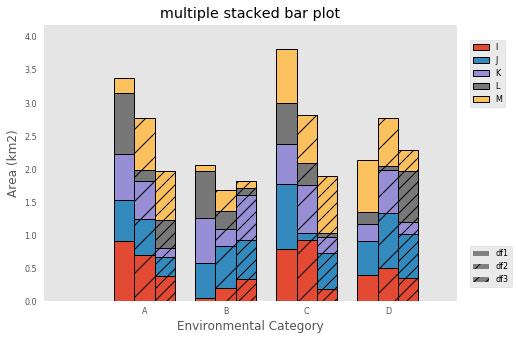

In [419]:

def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""
    plt.style.use('ggplot')
    #plt.figure(figsize=(2,3), dpi=300)
    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)
    plt.tight_layout()
    #plt.gcf().subplots_adjust(right=1.5)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=1,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))
                rect.set_edgecolor('black')
                rect.set_linewidth(1)

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 0)
    axe.set_ylabel("Area (km2)")
    axe.set_xlabel("Environmental Category")
    axe.set_title(title)
    axe.margins(y =0.1, x = 0.2, tight = True)
    axe.autoscale(True, tight=False)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.03, 0.7])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.03, 0.05]) 
    axe.add_artist(l1)
    #if kwargs.get("save"):
    #    axe.savefig(kwargs.get("save"), bbox_inches='tight')
    return axe

# create fake dataframes
df1 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df2 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"],
                   columns=["I", "J", "K", "L", "M"])
df3 = pd.DataFrame(np.random.rand(4, 5),
                   index=["A", "B", "C", "D"], 
                   columns=["I", "J", "K", "L", "M"])

# Then, just call :
plot_clustered_stacked([df1, df2, df3],["df1", "df2", "df3"])

## in this case, I need a dataframe per scenario (Basecase, HighDER, lowBatt, W2W)

In [420]:
scenList[0]

,Impacted sites,Unimpacted sites
envCat_scen,,
Base,5.713935,23.741246
Cat1,4.116252,24.109374
Cat2,10.102502,42.508033
Cat3,NaN,NaN


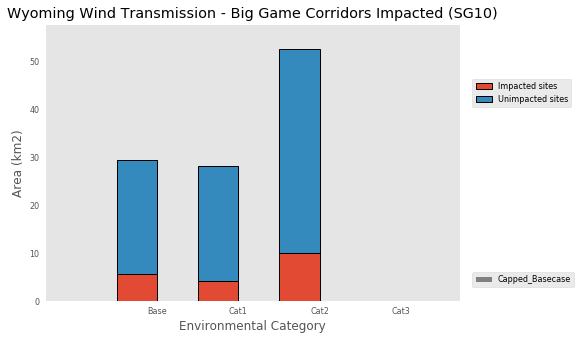

In [421]:
plot_clustered_stacked([scenList[0]],[RESOLVE_scenarioName_list[0]], title = "Wyoming Wind Transmission - Big Game Corridors Impacted (SG10)")#.savefig('C:\\Users\\Grace\\Documents\\TNC_beyond50\\PathTo100\\envImpactAssessment\\figures\\test.png')

In [58]:
[RESOLVE_scenarioName_list[0]]

['Capped_Basecase']

'\nh,l = axe.get_legend_handles_labels() # get the handles we want to modify\nfor i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df\n    for j, pa in enumerate(h[i:i+n_col]):\n        for rect in pa.patches: # for each index\n            rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))\n            rect.set_hatch(H * int(i / n_col)) #edited part     \n            rect.set_width(1 / float(n_df + 1))\n            rect.set_edgecolor(\'black\')\n            rect.set_linewidth(1)\n#h\n\naxe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)\naxe.set_xticklabels(df.index, rotation = 0)\naxe.set_ylabel("Area (km2)")\naxe.set_xlabel("Environmental Category")\naxe.set_title(title)\naxe.margins(y =0.1, x = 0.2, tight = True)\naxe.autoscale(True, tight=False)\n\n# Add invisible data to add another legend\nn=[]        \nfor i in range(n_df):\n    n.append(axe.bar(0, 0, color="gray", hatch=H * i))\n\nl1 = axe.legend(h[:n_col], l[:n_col], loc=[1.03, 0.7])\

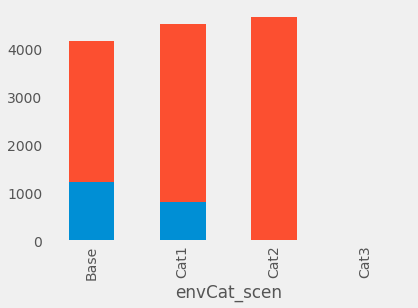

In [275]:
dfall = scenList
H="/"
plt.style.use('fivethirtyeight')
#plt.figure(figsize=(2,3), dpi=300)
n_df = len(dfall)
n_col = len(dfall[0].columns) 
n_ind = len(dfall[0].index)
axe = plt.subplot(111)
plt.tight_layout()
#plt.gcf().subplots_adjust(right=1.5)

for df in dfall : # for each data frame
    axe = df.plot(kind="bar",
                  linewidth=1,
                  stacked=True,
                  ax=axe,
                  legend=False,
                  grid=False)  # make bar plots

h,l = axe.get_legend_handles_labels() # get the handles we want to modify
for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
    for j, pa in enumerate(h[i:i+n_col]):
        for rect in pa.patches: # for each index
            rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
            rect.set_hatch(H * int(i / n_col)) #edited part     
            rect.set_width(1 / float(n_df + 1))
            rect.set_edgecolor('black')
            rect.set_linewidth(1)
'''
            #h

axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
axe.set_xticklabels(df.index, rotation = 0)
axe.set_ylabel("Area (km2)")
axe.set_xlabel("Environmental Category")
axe.set_title(title)
axe.margins(y =0.1, x = 0.2, tight = True)
axe.autoscale(True, tight=False)

# Add invisible data to add another legend
n=[]        
for i in range(n_df):
    n.append(axe.bar(0, 0, color="gray", hatch=H * i))

l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.03, 0.7])
if labels is not None:
    l2 = plt.legend(n, labels, loc=[1.03, 0.05]) 
axe.add_artist(l1)
#if kwargs.get("save"):
#    axe.savefig(kwargs.get("save"), bbox_inches='tight')
return axe
'''

In [280]:
enumerate(h[i:i+n_col])

[<BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>,
 <BarContainer object of 4 artists>]

In [32]:
print(plt.style.available)

['bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark-palette', 'seaborn-dark', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'seaborn', 'Solarize_Light2', 'tableau-colorblind10', '_classic_test']


In [148]:
xs = np.arange(8)
series1 = np.array([1, 3, 3, None, None, 5, 8, 9]).astype(np.double)
s1mask = np.isfinite(series1)
series2 = np.array([2, None, 5, None, 4, None, 3, 2]).astype(np.double)
s2mask = np.isfinite(series2)

In [151]:
print(series1)
s1mask

[ 1.  3.  3. nan nan  5.  8.  9.]


array([ True,  True,  True, False, False,  True,  True,  True])

## Scratch workspace

In [ ]:

## https://stackoverflow.com/questions/46597278/how-to-plot-a-stacked-and-grouped-bar-chart-in-ggplot

## https://stackoverflow.com/questions/43975244/displaying-r-ggplots-inline-in-jupyter-notebooks

# Hide warnings if there are any
import warnings
warnings.filterwarnings('ignore')
# Load in the r magic
%load_ext rpy2.ipython
# We need ggplot2
%R require(ggplot2)
# Load in the pandas library
import pandas as pd 
# Make a pandas DataFrame
df = pd.DataFrame({'Alphabet': ['a', 'b', 'c', 'd','e', 'f', 'g', 'h','i'],
                   'A': [4, 3, 5, 2, 1, 7, 7, 5, 9],
                   'B': [0, 4, 3, 6, 7, 10,11, 9, 13],
                   'C': [1, 2, 3, 1, 2, 3, 1, 2, 3]})
# Take the name of input variable df and assign it to an R variable of the same name
%R -i df
# Plot the DataFrame df
ggplot(data=df) + geom_point(aes(x=A, y=B, color=C))